# Objectifs

Les objectifs de la leçon sont les suivants:
* Fit une régression linéaire multiple avec `statsmodels`
* Interpréter la qualité de la régression linéaire multiple
* Vérifier les assumptions de la régression linéaire multiple

# Importer les librairies

In [1]:
#pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
from IPython.display import Image

# Data
from sklearn import datasets

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning
import statsmodels.api as sm

# Loader les données

In [3]:
# Loader les données
iris = datasets.load_iris()

# Obtenir les features
features = pd.DataFrame(
    data=iris.data,
    columns=iris.feature_names
)
# Obtenir la target
target = pd.DataFrame(
    data=iris.target,
    columns=["species"]
)
def target_converter(sp):
    """Apply strings to integers for the targets."""
    if sp == 0:
        return "setosa"
    elif sp == 1:
        return "versicolor"
    else:
        return "virginica"
target["species"] = target["species"].apply(target_converter)

# Concaténer les features et la target dans une meme dataframe
data = pd.concat([features, target], axis=1)

data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


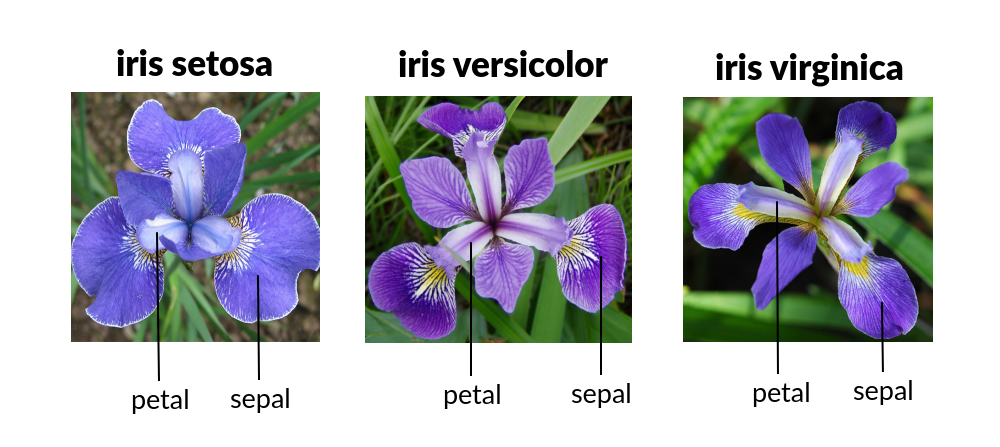

In [4]:
Image("Images/iris_flowers.png")

# (rapide) Analyse exploratoire des données

In [5]:
# Quelques statistics
data.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
# Manque-t-il des valeurs?
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


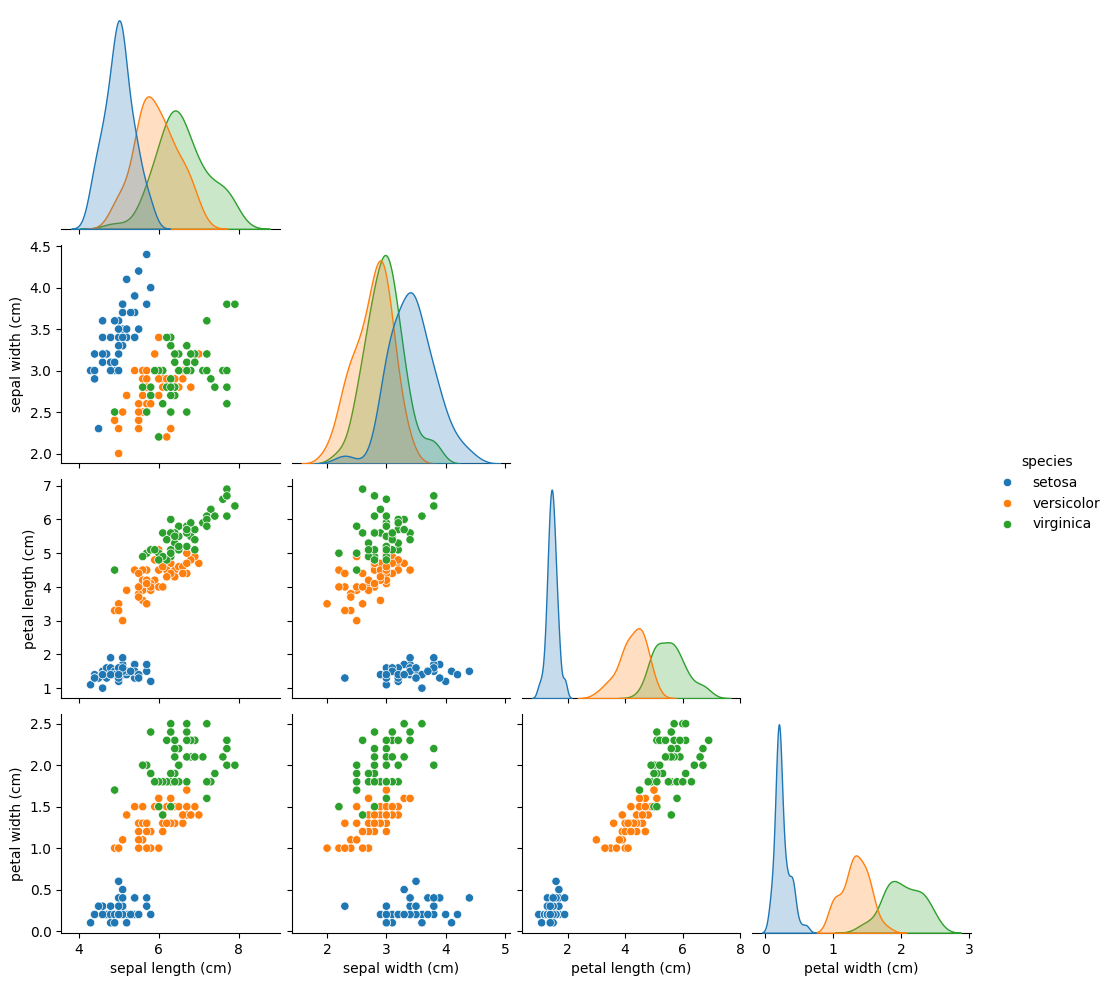

In [7]:
# Etudier la relation entre les variables, selon les species
sns.pairplot(
    data=data,
    hue="species",
    corner=True # pour eviter d'avoir les scatter plots en double
)
plt.show()

On remarque que les variables `petal length (cm)` et `petal width (cm)` sont positivement et fortement corrélées avec la variable `sepal length (cm)`, variable qui va être notre variable dépendente par la suite. En revanche, on remarque que la variable `sepal width (cm)` semble être négativement et faiblement corrélée avec `sepal length (cm)`. Enfin, on remarque que les variables `petal length (cm)` et `petal width (cm)` sont très fortement positivement corrélées (multicolinéarité).

In [8]:
# On peut calculer la correlation
data.corr(numeric_only=True)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


La table de corrélation confirme nos dires ci-dessus. On remarque également que l'unique variable catégorique `species` est ignorée (on n'utilise JAMAIS la corrélation pour estimer le lien entre une variable quantitative et une variable qualitative).

# Régression linéaire multiple

Pour une première régression linéaire multiple, nous allons utiliser la variable sepal length comme variable dépendente, et les autres variables comme variables indépendantes. Pour cela, nous allons utiliser la même fonction que pour la régression linéaire simple: [`statsmodels.OLS`](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html).

Cependant, la régression linéaire n'accepte pas les strings comme valeurs de colonne. Pour cela, nous allons encoder notre variable qualitative species. On appelle cela **One hot encoding** (https://en.wikipedia.org/wiki/One-hot). La fonction [`pd.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) permet cela en une ligne.

## Préparer les data pour la régression

In [9]:
# One-hot encoding
data = pd.get_dummies(
    data=data,
    columns=["species"], # la colonne à encoder
    drop_first=True, # on supprime l'une des colonnes encodée,
    dtype=int
)

data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species_versicolor,species_virginica
0,5.1,3.5,1.4,0.2,0,0
1,4.9,3.0,1.4,0.2,0,0
2,4.7,3.2,1.3,0.2,0,0
3,4.6,3.1,1.5,0.2,0,0
4,5.0,3.6,1.4,0.2,0,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0,1
146,6.3,2.5,5.0,1.9,0,1
147,6.5,3.0,5.2,2.0,0,1
148,6.2,3.4,5.4,2.3,0,1


Il faut de nouveau, comme pour la régression linéaire simple, que nous séparions en deux dataframes les features (toutes les variables sauf sepal length) et la target (sepal length).

In [10]:
# Séparer les features et la target
X = data[["sepal width (cm)", "petal length (cm)", "petal width (cm)", "species_versicolor", "species_virginica"]]
y = data[["sepal length (cm)"]]

Enfin, voici le modèle que nous allons produire:

$$ \underbrace{\text{sepal length}}_{y} = \text{const} 
                        + \underbrace{b_1 \cdot \text{sepal width} 
                        + b_2 \cdot \text{petal length} 
                        + b_3 \cdot \text{petal width}
                        + b_4 \cdot \text{species versicolor} 
                        + b_5 \cdot \text{species virginica}}_{X} $$

## Fit le modèle

In [11]:
# Générer un model de régression linéaire
model = sm.OLS(
    y,
    sm.add_constant(X) # il faut rajouter une constante, qui n'est pas là par défaut
)

# Fit le model
model_fit = model.fit()

# Quel est le résumé?
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:      sepal length (cm)   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     188.3
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           2.67e-61
Time:                        16:53:22   Log-Likelihood:                -32.558
No. Observations:                 150   AIC:                             77.12
Df Residuals:                     144   BIC:                             95.18
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.1713      0

Comment interpréter les coefficients ? Si l'on fixe tous les autres variables indépendentes fixes:
* Pour un centimètre supplémentaire de `sepal width (cm)`, on peut s'attendre à ce que la `sepal length (cm)` augmente de 0.5 centimètre.
* Pour un centimètre supplémentaire de `petal length (cm)`, on peut s'attendre à ce que la `sepal length (cm)` augmente de 0.83 centimètre.
* Pour un centimètre supplémentaire de `petal width (cm)`, on peut s'attendre à ce que la `sepal length (cm)` diminue de 0.32 centimètre.
* Comparé à l'espèce Setosa, l'espèce versicolor est associée à une diminution de 0.72 centimètre de `sepal length (cm)`.
* Comparé à l'espèce Setosa, l'espèce virginica est associée à une diminution de 1.02 centimètre de `sepal length (cm)`.

# Check des assumptions

Voici le lien utilisé pour générer les graphs suivants: [`https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/`](https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/).

In [12]:
from statsmodels.graphics.gofplots import ProbPlot
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model in R.

    ---
    Inputs:

    X: A numpy array or pandas dataframe of the features to use in building the linear regression model
    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
    """

    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()

    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)
    
    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
    
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(x = model_fitted_y, y = dataframe.columns[-1], data = dataframe,
                                      lowess=True,
                                      scatter_kws={'alpha': 0.5},
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals');
    
    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_residuals[i]));
        
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
    
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]));
    
    plot_lm_3 = plt.figure()
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
    sns.regplot(x = model_fitted_y, y = model_norm_residuals_abs_sqrt,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');
    
    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_norm_residuals_abs_sqrt[i]));
    
    plot_lm_4 = plt.figure();
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
    sns.regplot(x = model_leverage, y = model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals');
    
    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i,
                                   xy=(model_leverage[i],
                                       model_norm_residuals[i]));
        
    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50),
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50)) # 1 line
    plot_lm_4.legend(loc='upper right');

<>:92: SyntaxWarning: invalid escape sequence '\s'
<>:92: SyntaxWarning: invalid escape sequence '\s'
/var/folders/rm/zd360c_n3394v5zq_gnyj9s00000gn/T/ipykernel_68459/2222118861.py:92: SyntaxWarning: invalid escape sequence '\s'
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');


/Users/levkiwi/Dev/62-62.2-Data-Analysis/.venv/lib/python3.12/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


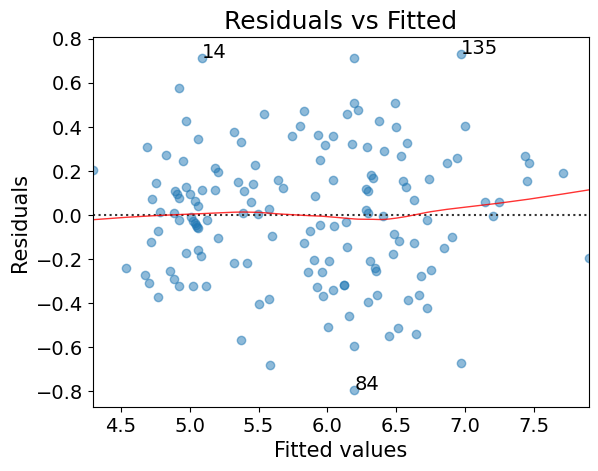

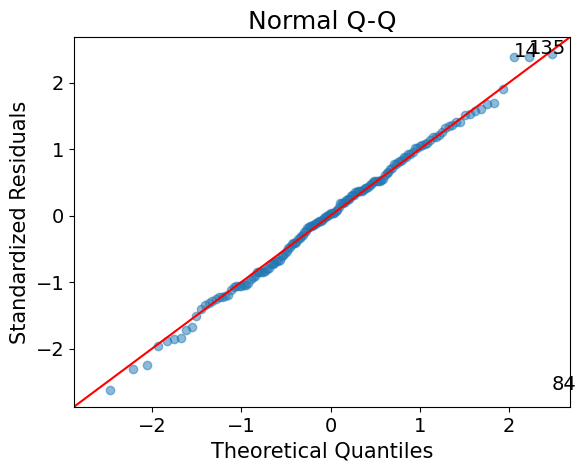

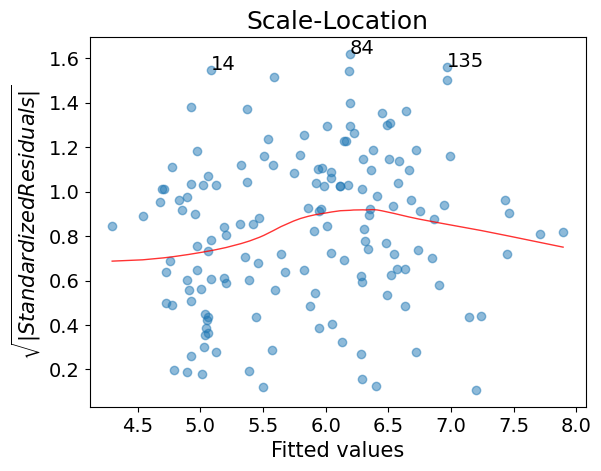

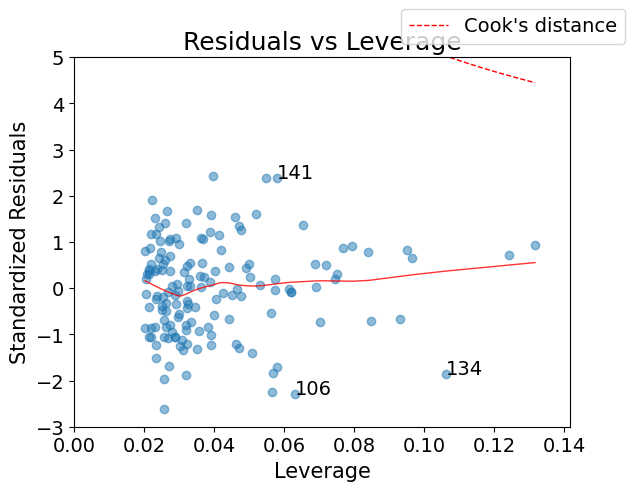

In [13]:
diagnostic_plots(X, y, model_fit=model_fit)

## 1. Relation linéaire

Il doit exister un lien linéaire entre la variable dépendente et les variables indépendentes.

Le graph `Residuals versus Fitted` nous permet de valider cette assumption. La ligne rouge semble assez droite, ce qui veut dire qu'il semble exister une relation linéaire entre `sepal length` et les variables indépendentes.

## 2. Echantillon aléatoire

Nous assumons que notre échantillon est aléatoire.

## 3. Pas de multicolinéarité

Les variables indépendantes ne doivent pas être hautement corrélées entre elles.

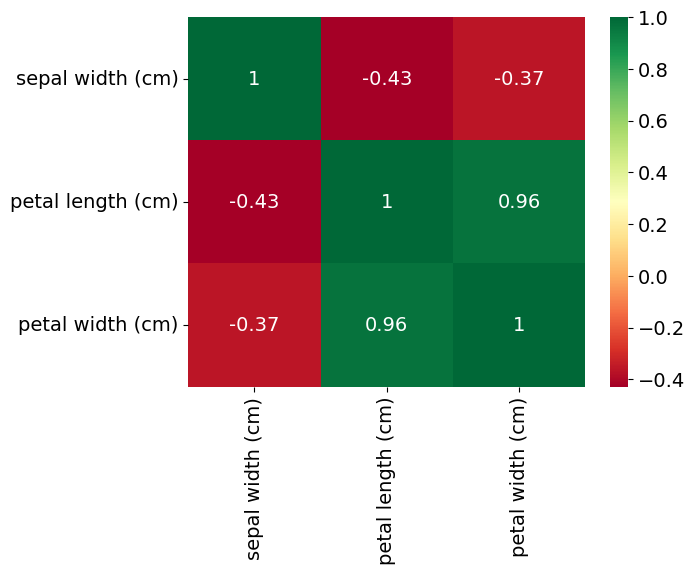

In [14]:
# On drop les variables catégoriques et la target
sns.heatmap(
    data.drop(columns=["sepal length (cm)", "species_versicolor", "species_virginica"]).corr(), 
    annot=True,
    cmap='RdYlGn'
)
plt.show()

Il n'y a pas de parfaite correlation entre les variables mais il y a une forte correlation entre la `petal width` et la `petal length` (et cela semble faire du sens). Supprimer l'une des deux variables pourrait potentiellement améliorer le model.

In [15]:
# Séparer les features et la target
# Cette fois, on supprime l'une des deux variables corrélées
X = data[["sepal width (cm)", "petal length (cm)", "species_versicolor", "species_virginica"]]
y = data[["sepal length (cm)"]]

# Générer un model de régression linéaire
model = sm.OLS(
    y,
    sm.add_constant(X) # il faut rajouter une constante, qui n'est pas là par défaut
)

# Fit le model
model_fit = model.fit()

# Quel est le résumé?
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:      sepal length (cm)   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     228.9
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           1.40e-61
Time:                        16:53:23   Log-Likelihood:                -34.787
No. Observations:                 150   AIC:                             79.57
Df Residuals:                     145   BIC:                             94.63
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3904      0

On remarque que le coefficient de détermination a à peine diminué (il est passé de 86.7% à 86.3%), une différence peu significative. Aussi, nous avons réduit la complexité de l'algorithme en enlevant la variable `petal width (cm)`, hautement corrélée avec la variable `petal length (cm)`, qui explique le même phénomène. 

Comment interpréter les coefficients ? Si l'on fixe tous les autres variables indépendentes fixes:
* Pour un centimètre supplémentaire de `sepal width (cm)`, on peut s'attendre à ce que la `sepal length (cm)` augmente de 0.43 centimètre.
* Pour un centimètre supplémentaire de `petal length (cm)`, on peut s'attendre à ce que la `sepal length (cm)` augmente de 0.78 centimètre.
* Comparé à l'espèce Setosa, l'espèce versicolor est associée à une diminution de 0.96 centimètre de `sepal length (cm)`.
* Comparé à l'espèce Setosa, l'espèce virginica est associée à une diminution de 1.4 centimètre de `sepal length (cm)`.

## 4. Les résidus suivent une loi normale centré à 0

Sur le graph `Normal QQ`, les résidues sont plutôt bien (pas parfaitement) alignés sur la diagonale ce qui montre que les résidus semblent suivre une distribution normale.

## 5. Les résidus ont une variance constante.

Les résidues sur le graph `Scale - Location` ont une variance qui semble constante puisque la ligne est plutôt horizontal que la forme d'un V.